In [0]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
import time

In [3]:
data = pd.read_csv('/content/y2015_to_2017_buffer_750.csv')

# drop rows with any null value
data.dropna(inplace = True)

# drop columns:
# remaining_lease: 
data.drop([
    'geometry', # for processing only
    'remaining_lease', # duplicate of remaining_lease_month
    'street_name', # random
    'address',  # random
    'block', # random
    'floor_area_sqm', # feature used to create target
    'age_month', # highly correlated to remaining_lease_month
    'lease_commence_date', # var used to create remaining_lease_month
    'transaction_month', # limited use
    'resale_price', # highly correlated to target
    'month' # duplicate of transaction_date
], axis=1, inplace=True)

# log price_per_sqm
data['price_per_sqm'] = data['price_per_sqm'].apply(lambda x: np.log(1 + x))

# cut postal code to only be first 3 digits
data['postal'] = data['postal'].apply(lambda x: int(str(x)[:3]))

# change storey_range to average of floors, to change categorical to numerical
data['storey_range'] = data['storey_range'].apply(lambda x: (int(x[:2]) + int(x[-2:]))/2)

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
data

,town,flat_type,storey_range,flat_model,transaction_year,price_per_sqm,remaining_lease_month,postal,mallCount,busInterchangeCount,sportsCount,hawkerCount,npParkCount,preschoolCount,primarySchCount,secondarySchCount,tertiarySchCount,dist_nearestMRT
0,ANG MO KIO,3 ROOM,8.0,Improved,2015,8.354910,840.0,560,0.0,0.0,0.0,0.0,2.0,12.0,2.0,1.0,1.0,1.697526
1,ANG MO KIO,3 ROOM,2.0,New Generation,2015,8.305266,780.0,560,0.0,0.0,0.0,0.0,0.0,9.0,1.0,1.0,0.0,0.497407
2,ANG MO KIO,3 ROOM,2.0,New Generation,2015,8.326379,768.0,560,0.0,0.0,0.0,0.0,2.0,11.0,2.0,2.0,1.0,1.697526
3,ANG MO KIO,3 ROOM,2.0,New Generation,2015,8.326379,756.0,560,0.0,0.0,0.0,0.0,2.0,11.0,2.0,2.0,1.0,1.697526
4,ANG MO KIO,3 ROOM,2.0,New Generation,2015,8.358364,756.0,560,0.0,0.0,0.0,0.0,0.0,11.0,2.0,1.0,0.0,0.497407
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
108925,YISHUN,EXECUTIVE,2.0,Maisonette,2020,8.232073,809.0,761,0.0,0.0,0.0,0.0,1.0,15.0,3.0,1.0,0.0,0.630638
108926,YISHUN,EXECUTIVE,2.0,Apartment,2020,8.307923,857.0,760,1.0,1.0,1.0,1.0,0.0,12.0,2.0,2.0,1.0,0.654036
108927,YISHUN,EXECUTIVE,2.0,Maisonette,2020,8.260348,803.0,760,2.0,1.0,1.0,1.0,0.0,13.0,2.0,3.0,0.0,0.654036
108928,YISHUN,EXECUTIVE,2.0,Maisonette,2020,8.234331,803.0,760,1.0,0.0,1.0,1.0,0.0,15.0,3.0,3.0,0.0,0.654036


In [5]:
data.head()

,town,flat_type,storey_range,flat_model,transaction_year,price_per_sqm,remaining_lease_month,postal,mallCount,busInterchangeCount,sportsCount,hawkerCount,npParkCount,preschoolCount,primarySchCount,secondarySchCount,tertiarySchCount,dist_nearestMRT
0,ANG MO KIO,3 ROOM,8.0,Improved,2015,8.354910,840.0,560,0.0,0.0,0.0,0.0,2.0,12.0,2.0,1.0,1.0,1.697526
1,ANG MO KIO,3 ROOM,2.0,New Generation,2015,8.305266,780.0,560,0.0,0.0,0.0,0.0,0.0,9.0,1.0,1.0,0.0,0.497407
2,ANG MO KIO,3 ROOM,2.0,New Generation,2015,8.326379,768.0,560,0.0,0.0,0.0,0.0,2.0,11.0,2.0,2.0,1.0,1.697526
3,ANG MO KIO,3 ROOM,2.0,New Generation,2015,8.326379,756.0,560,0.0,0.0,0.0,0.0,2.0,11.0,2.0,2.0,1.0,1.697526
4,ANG MO KIO,3 ROOM,2.0,New Generation,2015,8.358364,756.0,560,0.0,0.0,0.0,0.0,0.0,11.0,2.0,1.0,0.0,0.497407


In [0]:
# categorical_vars = ['town', 'flat_type', 'block', 'street_name', 'storey_range', 'flat_model']
categorical_vars = [['town', 'town'], ['flat_type', 'ft'], ['flat_model', 'fm']]

for cat in categorical_vars:
    data[cat[0]] = pd.Categorical(data[cat[0]])
    catDummies = pd.get_dummies(data[cat[0]], prefix = cat[1])
    data = pd.concat([data, catDummies], axis=1)
    data.drop(cat[0], axis=1, inplace=True)

In [7]:
data.shape

(106767, 68)

In [0]:
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split

In [9]:
#Seperate datasets

X = data.drop('price_per_sqm', axis=1)
Y = data['price_per_sqm']

print(X.shape)
print(Y.shape)

X.dtypes

(106767, 67)
(106767,)


storey_range             float64
transaction_year           int64
remaining_lease_month    float64
postal                     int64
mallCount                float64
                          ...   
fm_Simplified              uint8
fm_Standard                uint8
fm_Terrace                 uint8
fm_Type S1                 uint8
fm_Type S2                 uint8
Length: 67, dtype: object

In [0]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Support Vector Regression with different kernels
svr_rbf = SVR(kernel='rbf',cache_size=1000, gamma='auto')

In [11]:
svr_rbf.fit(x_train, y_train)
%time

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.91 µs


In [12]:
pred_svr_rbf = svr_rbf.predict(x_test)
%time

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 11 µs
CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 11 µs


In [13]:
from sklearn.metrics import mean_absolute_error, r2_score
r2 = r2_score(y_test.values, pred_svr_rbf)

r2

0.8909828697243258

0.8909828697243258

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.ensemble.forest module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.
  warnings.warn(message, FutureWarning)


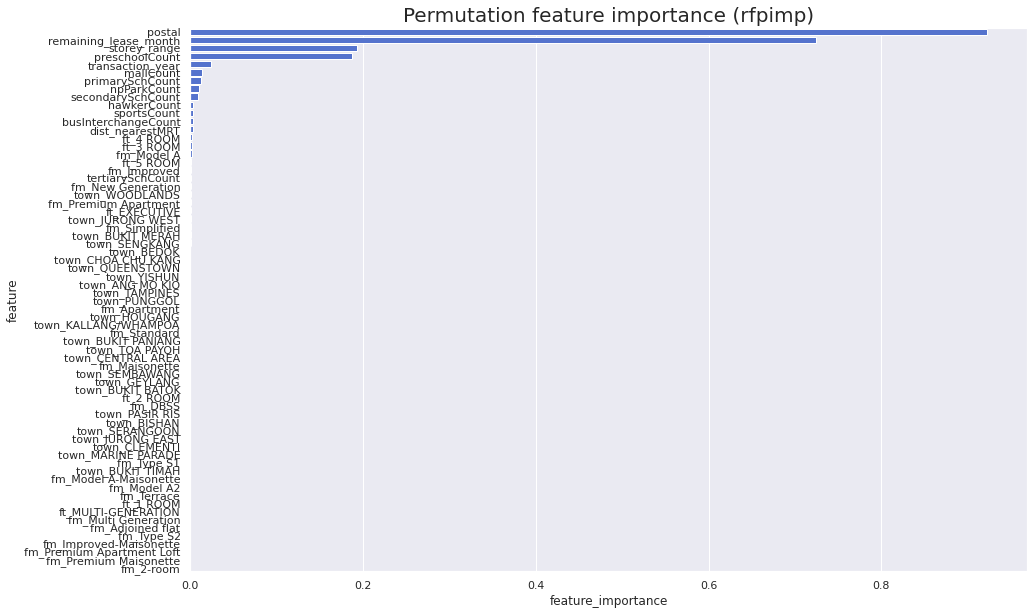

In [16]:
from sklearn.metrics import r2_score
from rfpimp import permutation_importances

def r2(RFR, x_train, y_train):
    return r2_score(y_train, RFR.predict(x_train))

perm_imp_rfpimp = permutation_importances(svr_rbf, x_train, y_train, r2)

# visualisations
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set_style("whitegrid")
sns.set(rc = {'figure.figsize':(15, 10)})

# plotting a feature importance dataframe (horizontal barchart)

def var_imp_plot(imp_df, title):
    imp_df = imp_df.reset_index()
    imp_df.columns = ['feature', 'feature_importance']
    sns.barplot(x = 'feature_importance', y = 'feature', data = imp_df, orient = 'h', color = 'royalblue').set_title(title, fontsize = 20)

var_imp_plot(perm_imp_rfpimp, 'Permutation feature importance (rfpimp)')


In [15]:
!pip install rfpimp

  Created wheel for rfpimp: filename=rfpimp-1.3.4-cp36-none-any.whl size=10086 sha256=2c49e2f77630d2079459a23400e9d68a9c28c8c053d3363921e3ae2d9b298951
  Stored in directory: /root/.cache/pip/wheels/c7/35/67/4065afd69df4c0be693ecdec8a9c1433a23f80ee60395272ba
Successfully built rfpimp
